# Titanic Kaggle Competition

**The Challenge**<br>
The sinking of the Titanic is one of the most infamous shipwrecks in history.<br>

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.<br>

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.<br>

The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

**Methodology and Sections**
- Data Understanding - evaluation of datasets provided, with visualisation of distributions and analysis of data types.<br>
- Data Preparation - train dataset split into train_data and validation_data, followed by data cleaning, label encoding for categorical features and normalisation of all datasets.
- Modelling - implementation of different models analysing the best model available. At this stage it was performed cross validation, feature selection and hyperparameters tuning.
- Evaluation - results score of best model from Modelling stage upon prediction of validation data.
- Submission File Preparation - use of chosen model for prediction on test data (previously unseen and which had no influence on previous steps). As the Kaggle challenge doesn't provide labels for this dataset, the prediction results are ordered in a csv file for upload to Kaggle.

**Results**<br>
Submission on Kaggle resulted in an accuracy score of 0.75837 (approximately 75.8%) as seen in screenshot below.<br>
This was a first submission to the challenge. The next steps will be to continue to test different approaches to increase the score to above 80%.

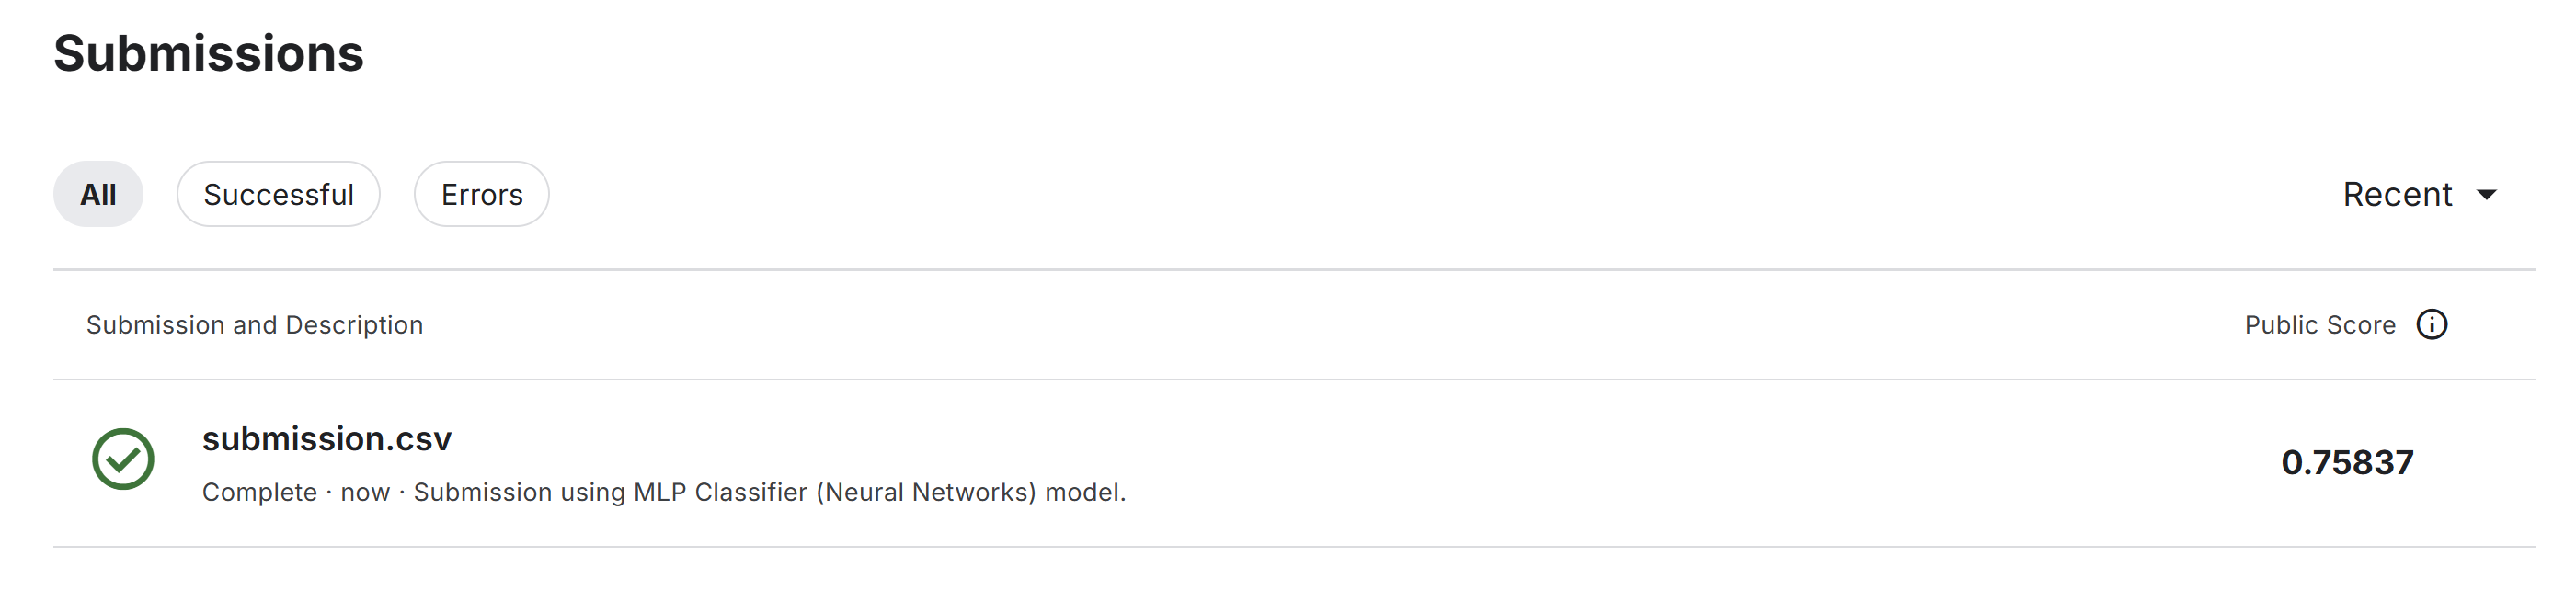

## Libraries and Dataset Import

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, mutual_info_classif 
from sklearn import preprocessing 

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Understanding

From this stage, we can already observe a few features that need to be removed during Data Preparation due to their values being specific to each individual, and therefore not presenting any trends or patterns to the model. Those features include the PassengerId (passenger unique identifier), Name (passenger name) and Ticket (id of a ticket). Cabin is a feature that presents too many NaN values, most likely being dropped as well.<br><br>
Embarked feature presents 2 records with null value, while Age feature presents 177 records with null value. To treat those, Embarked nulls will be set as "M" for Missing and Age nulls will be marked as the mean of the feature.<br><br>
The target feature, entitled 'Survive', is not a balanced feature, however the probability of survival is lower, therefore this will be kept as it is instead of performing oversampling/undersampling for balancing of target.

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Checks for missing values in each column
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

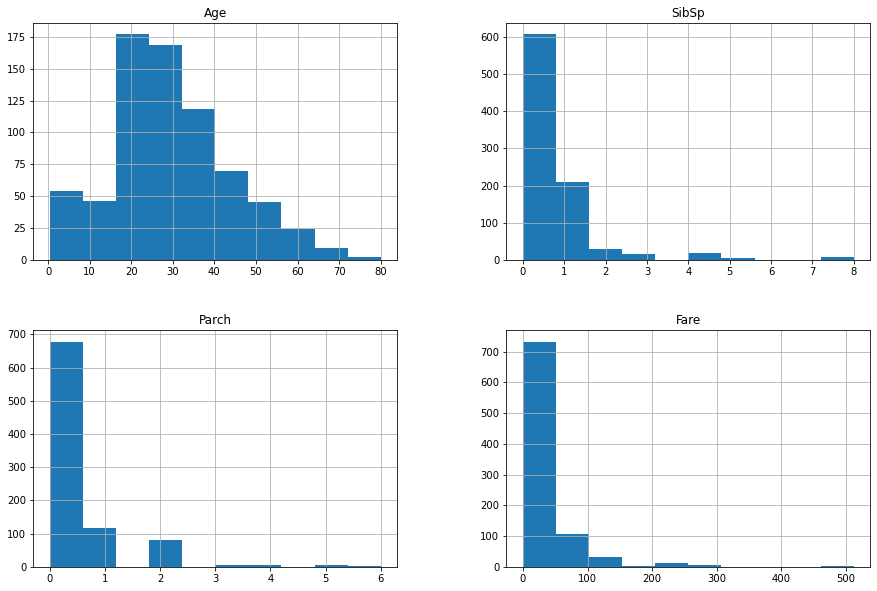

In [7]:
#Visualise numerical continuous fields
fig, axis = plt.subplots(2,2, figsize=(15,10))
train[['Age','SibSp','Parch','Fare']].hist(ax=axis)

Text(0.5, 1.0, 'Embarked')

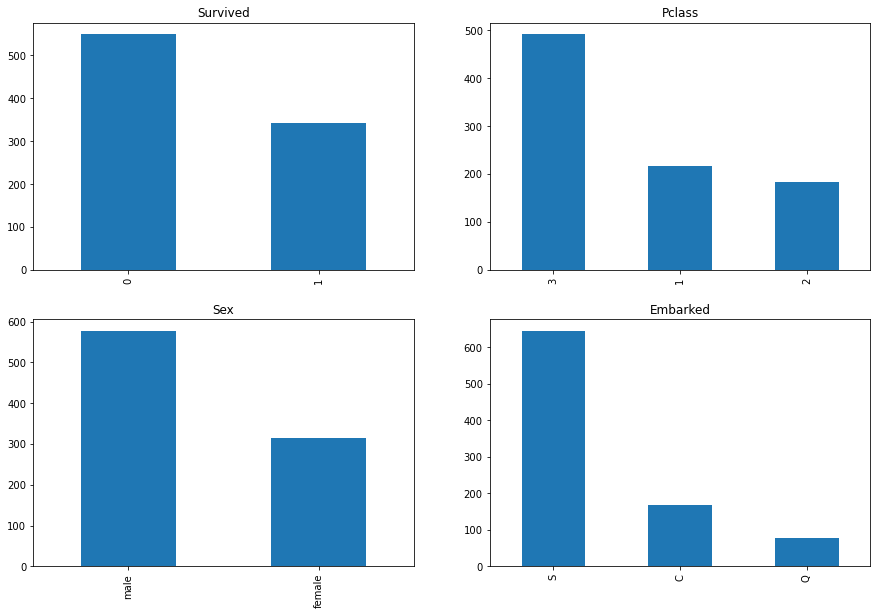

In [8]:
# Visualise nominal fields
fig, axes = plt.subplots(2, 2, figsize=(15,10))
axes = axes.flatten()

train['Survived'].value_counts().plot(ax=axes[0], kind='bar')
axes[0].set_title('Survived')
train['Pclass'].value_counts().plot(ax=axes[1], kind='bar')
axes[1].set_title('Pclass')
train['Sex'].value_counts().plot(ax=axes[2], kind='bar')
axes[2].set_title('Sex')
train['Embarked'].value_counts().plot(ax=axes[3], kind='bar')
axes[3].set_title('Embarked')

## Data Preparation

In [10]:
# Define target feature and separate data and labels
target_column = 'Survived'
X = train.drop(columns=[target_column])
y = train[target_column]

# Split the data into training (80%) and validation (20%) sets
train_data, validation_data, train_labels, validation_labels = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
''' Data Cleaning steps include removal of features not suitable for modelling and indexing of PassengerId'''

def DataCleaning(df):
    # Treat missing values
    df['Age'].fillna(df['Age'].median(),inplace=True) # fill it with columns median
    df['Embarked'].fillna('M',inplace=True) # fill it as M for missing
    df = df.fillna(df.mean()) # fill any other nulls with mean - this avoids future errors
    
    # Drop individual's columns
    df = df.drop(columns=['Name','Ticket','Cabin'])
    
    # Set Id as index
    df = df.set_index('PassengerId')
    return df

In [12]:
''' The below function perform one-hot encoding for categorical features and apply MinMaxScaler to the dataset'''

def EncodingAndNormalisation(df):
    
    # Encode label of categorical features
    label_encoder = preprocessing.LabelEncoder() 
    df['Embarked']= label_encoder.fit_transform(df['Embarked']) 
    df['Sex']= label_encoder.fit_transform(df['Sex']) 
    
    # Normalisation of the data
    normalisationMethod = MinMaxScaler().fit(df)
    df = normalisationMethod.transform(df)
    
    return df

In [13]:
train_data = DataCleaning(train_data)
train_data = EncodingAndNormalisation(train_data)

validation_data = DataCleaning(validation_data)
validation_data = EncodingAndNormalisation(validation_data)

test_data = DataCleaning(test)
test_data = EncodingAndNormalisation(test_data)

## Modelling

In [14]:
# Definition of the models
nn_model = MLPClassifier(max_iter=2000)
lr_model = LogisticRegression()
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()
gnb_model = GaussianNB()
svm_model = svm.SVC()

In [15]:
# Cross Validation of each model
# Neural Networks
nn_cv_score = cross_val_score(nn_model, train_data, train_labels, cv=10)
nn_avg_score = np.average(nn_cv_score)

# Logistic Regression
lr_cv_score = cross_val_score(lr_model, train_data, train_labels, cv=10)
lr_avg_score = np.average(lr_cv_score)

# Decision Tree
dt_cv_score = cross_val_score(dt_model, train_data, train_labels, cv=10)
dt_avg_score = np.average(dt_cv_score)

# Random Forest
rf_cv_score = cross_val_score(rf_model, train_data, train_labels, cv=10)
rf_avg_score = np.average(rf_cv_score)

# Gaussian Naive Bayes
gnb_cv_score = cross_val_score(gnb_model, train_data, train_labels, cv=10)
gnb_avg_score = np.average(gnb_cv_score)

# Support Vector Machine
svm_cv_score = cross_val_score(svm_model, train_data, train_labels, cv=10)
svm_avg_score = np.average(svm_cv_score)

In [16]:
print('\033[1m',"Cross Validation Average Score:",'\033[0m')
print(f"Neural Networks - {(nn_avg_score*100):.2f}%")
print(f"Logistic Regression - {(lr_avg_score*100):.2f}%")
print(f"Decision Tree - {(dt_avg_score*100):.2f}%")
print(f"Random Forest - {(rf_avg_score*100):.2f}%")
print(f"Gaussian Naive Bayes - {(gnb_avg_score*100):.2f}%")
print(f"Support Vector Machine - {(svm_avg_score*100):.2f}%")

 Cross Validation Average Score: 
Neural Networks - 82.03%
Logistic Regression - 79.21%
Decision Tree - 76.41%
Random Forest - 80.06%
Gaussian Naive Bayes - 79.63%
Support Vector Machine - 80.76%


In [17]:
counter = 1
results_df = pd.DataFrame(columns=['K Value', 'NN Model', 'RF Model', 'SVM Model', 'Features'])
feature_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']

for k in range(1,8):
    fs = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = fs.fit_transform(train_data, train_labels)
    X_val_selected = fs.transform(validation_data)
    
    # Implement selected features and analyse model accuracy - perform this step for each of the models
    
    # Neural Networks
    new_nn = MLPClassifier(max_iter=2000) # Create a new model for each iteration
    new_nn.fit(X_train_selected, train_labels)
    new_nn_predictions = new_nn.predict(X_val_selected)
    new_nn_accuracy = accuracy_score(validation_labels, new_nn_predictions)
    
    # Random Forest
    new_lr = LogisticRegression()
    new_lr.fit(X_train_selected, train_labels)
    new_lr_predictions = new_lr.predict(X_val_selected)
    new_lr_accuracy = accuracy_score(validation_labels, new_lr_predictions)
    
    # SVM
    new_svm = svm.SVC()
    new_svm.fit(X_train_selected, train_labels)
    new_svm_predictions = new_svm.predict(X_val_selected)
    new_svm_accuracy = accuracy_score(validation_labels, new_svm_predictions)
    
    # Match the boolean results with the relevant features names
    selected_features_indices = fs.get_support().nonzero()[0]
    selected_feature_names = [feature_names[i] for i in selected_features_indices]

    new_row = {'K Value':k, 'NN Model':new_nn_accuracy, 'RF Model':new_lr_accuracy, 
               'SVM Model':new_svm_accuracy, 'Features':selected_feature_names}
    results_df = results_df.append(new_row, ignore_index=True)
    
    counter+=1

In [18]:
# Check table with results of feature selection process
results_df

,K Value,NN Model,RF Model,SVM Model,Features
0,1,0.782123,0.782123,0.782123,[Age]
1,2,0.782123,0.776536,0.776536,"[Age, Sex]"
2,3,0.776536,0.782123,0.765363,"[Pclass, Age, Sex]"
3,4,0.793296,0.765363,0.793296,"[Pclass, Age, Sex, Embarked]"
4,5,0.776536,0.776536,0.798883,"[Pclass, Age, Parch, Fare, Sex]"
5,6,0.798883,0.793296,0.793296,"[Pclass, Age, SibSp, Parch, Sex, Embarked]"
6,7,0.815642,0.804469,0.798883,"[Pclass, Age, SibSp, Parch, Fare, Sex, Embarked]"


Based on above table, K value as 7 (index 6) where all features are used presents the best result, achieving 81.56% accuracy for Neural Networks model.

In [19]:
# Perform hyperparameter tuning with the model that best performed in the Cross Validation step: Neural Networks

nn_hyperparameters = {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
                      'activation': ['relu', 'tanh', 'logistic'],
                      'solver': ['adam', 'sgd', 'lbfgs'],
                      'learning_rate': ['constant', 'invscaling', 'adaptive'],
                      'alpha': [0.0001, 0.001, 0.01],
                      'batch_size': ['auto', 32, 64]}

nn_grid = GridSearchCV(MLPClassifier(), nn_hyperparameters, refit=True, verbose=1)
nn_grid.fit(train_data, train_labels)

print(nn_grid.best_params_)
print(nn_grid.best_estimator_)

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
{'activation': 'logistic', 'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'invscaling', 'solver': 'lbfgs'}
MLPClassifier(activation='logistic', alpha=0.01, batch_size=64,
              hidden_layer_sizes=(100, 50), learning_rate='invscaling',
              solver='lbfgs')


## Evaluation

In [20]:
nn_final_model = MLPClassifier(activation='logistic', alpha=0.01, batch_size=64,
              hidden_layer_sizes=(100, 50), learning_rate='invscaling', solver='lbfgs')
nn_final_model.fit(train_data, train_labels)

nn_predictions = nn_final_model.predict(validation_data)
nn_accuracy = accuracy_score(validation_labels, nn_predictions)

print('Accuracy: ', nn_accuracy)

Accuracy:  0.770949720670391


In [23]:
# Model quality metrics including Accuracy, Precision, Recall and F1 Score
print(classification_report(validation_labels, nn_predictions))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       105
           1       0.74      0.69      0.71        74

    accuracy                           0.77       179
   macro avg       0.77      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



## Submission File Preparation

In [47]:
test_data = DataCleaning(test)
test_data = EncodingAndNormalisation(test_data)

In [48]:
# Predict test data for competition submission
nn_predictions = nn_final_model.predict(test_data)

# Create submission csv file
output = pd.DataFrame({'PassengerId':test.PassengerId,
                       'Survived':nn_predictions
                      })
output.to_csv('submission.csv',index=False, encoding='utf-8')

In [49]:
output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
